### NAMLSS Code & Helper Functions

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

class NormalNAMLSS(nn.Module):
    def __init__(self, n_covariates, hidden_size=8, intercept=False):
        super(NormalNAMLSS, self).__init__()

        self.submodules = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 2)
            ) for _ in range(n_covariates)
        ])

        self.use_intercept = intercept
        if self.use_intercept:
            self.intercept = nn.Parameter(torch.zeros(2))

    def forward(self, x):
        param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
        x = torch.stack(param_mat_list, dim=1)
        mu_components = x[:, :, 0]
        sigma_components = F.softplus(x[:, :, 1])

        mu = torch.sum(mu_components, dim=1).unsqueeze(dim=1)
        sigma = torch.sum(sigma_components, dim=1).unsqueeze(dim=1)

        if self.use_intercept:
            mu = mu + self.intercept[0]
            sigma = sigma + F.softplus(self.intercept[1])

        return mu, sigma

    def nll_loss(self, mu, sigma, y_true, robustness_factor=None):
        normal_dist = dist.Normal(mu, sigma)
        # log_likelihood = normal_dist.log_prob(y_true).sum()
        log_likelihood = normal_dist.log_prob(y_true).mean()

        if robustness_factor is not None:
            # log_likelihood = torch.log((1 + torch.exp(normal_dist.log_prob(y_true) + robustness_factor)) / (1 + torch.exp(robustness_factor))).sum()
            log_likelihood = torch.log((1 + torch.exp(normal_dist.log_prob(y_true) + robustness_factor)) / (1 + torch.exp(robustness_factor))).mean()

        nll = -log_likelihood
        return nll


    def fit(self, X_train, y_train, X_val=None, y_val=None, n_epochs=10000, lr=1e-3, weight_decay=0.0, 
            early_stopping_patience=10, robustness_factor=None):

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(n_epochs):
            self.train()

            # Forward pass and loss computation
            mu, sigma = self.forward(X_train)
            train_loss = self.nll_loss(mu, sigma, y_train, robustness_factor)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            val_loss = None
            if X_val is not None and y_val is not None:
                self.eval()
                with torch.no_grad():
                    mu_val, sigma_val = self.forward(X_val)
                    val_loss = self.nll_loss(mu_val, sigma_val, y_val, robustness_factor).item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = self.state_dict()
                else:
                    patience_counter += 1

                if (patience_counter >= early_stopping_patience) and (epoch >= 1000):
                    print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
                    self.load_state_dict(best_model_state)
                    break

            if epoch % 100 == 0 or val_loss is not None:
                # print(f"Epoch {epoch} - Train Loss: {train_loss.item():.4f} - Val Loss: {val_loss:.4f}" if val_loss else f"Epoch {epoch} - Train Loss: {train_loss.item():.4f}")
                pass

        return self
    
    def predict(self, x):
        mu, sigma = self.forward(x)

        mu = mu.detach()
        sigma = sigma.detach()

        return mu, sigma
        

    def marginal_effects(self, x):
        with torch.no_grad():
            param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
            x = torch.stack(param_mat_list, dim=1)
            mu_components = x[:, :, 0].detach().cpu().numpy()
            sigma_components = F.softplus(x[:, :, 1]).detach().cpu().numpy()
        return mu_components, sigma_components

In [ ]:
def F1(X):
    return (2 * X + torch.sin(X * 2.5 * torch.pi)).squeeze()

def F2(X):
    return (3 - 3 * X ** 2).squeeze()

def F3(X):
    return (12 * (X - 0.5) ** 2).squeeze()

def S1(X):
    return torch.exp(-0.5 + 2 * X - 1.5 * X ** 2).squeeze()

def S2(X):
    return abs(1.2 - 1/2 * X).squeeze()

def S3(X):
    return (X/X).squeeze()

In [88]:
def rho_gradient(z, c):
    return np.exp(z + c)/(1 + np.exp(z + c))

In [89]:
import numpy as np

def get_aeberhard_penalty(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, target_mdp):

    rob_vec = torch.tensor(list(np.arange(5, 0, -0.1)), dtype = torch.float32)
    n_var = X_train_scaled.shape[1]
    
    prev_mdp = 0
    best_rob = None

    for rob in rob_vec:
        prev_distance = abs(prev_mdp - target_mdp)
        w_b_vector = []

        candidate_model = NormalNAMLSS(n_var)
        candidate_model.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor = rob)
        mu, sigma = candidate_model.predict(X_train_scaled)

        normal_dist = dist.Normal(mu, sigma)

        for _ in range(10):
            y_b = torch.normal(mu, sigma)
            ll = normal_dist.log_prob(y_b)
            w_1b = rho_gradient(ll, rob)
            w_b = torch.sum(w_1b) / len(y_b)
            w_b_vector.append(w_b)

        current_mdp = 1 - torch.median(torch.tensor(w_b_vector, dtype = torch.float32))
        current_distance = abs(current_mdp - target_mdp)

        if current_distance > prev_distance:
            print(f"stopping at {best_rob} --> mdp: {prev_mdp * 100}%")
            break

        best_rob = rob
        prev_mdp = current_mdp

    return best_rob

### Simulation using 3 Covariates

List of Corruption Proportions and corresponding aeberhard robustness settings at 5% and 10% MDP:
- 0% --> 4.5, 3.6
- 5% --> 4.3, 3.4
- 10% --> 4.3, 3.2
- 15% --> 4.3, 3.3
- 20% --> 4.6, 3.7

In [ ]:
import random
import numpy as np
import torch.distributions as dist
from sklearn.preprocessing import StandardScaler

def simulation_run(prop_corrupt, robust_c, strict_c):

    ########## Drawing Covariate Samples ##########
    n_train, n_val, n_test = 10000, 10000, 10000
    n_var = 3
    Uniform = dist.Uniform(0, 1)

    X_train = Uniform.sample(sample_shape = [n_train, n_var])
    X_val = Uniform.sample(sample_shape = [n_val, n_var])
    X_test = Uniform.sample(sample_shape = [n_test, n_var])

    ########## Training Dataset ##########
    F1_train = F1(X_train[:,0])
    F2_train = F2(X_train[:,1])
    F3_train = F3(X_train[:,2])

    S1_train = S1(X_train[:,0])
    S2_train = S2(X_train[:,1])
    S3_train = S3(X_train[:,2])

    y_train = torch.normal(mean = F1_train + F2_train + F3_train, std = S1_train + S2_train + S3_train)
    corrupted_train_indices = torch.tensor(random.sample(range(1, n_train), int(n_train * prop_corrupt)))
    y_train[corrupted_train_indices] = torch.normal(torch.ones(len(corrupted_train_indices)) * 15, torch.ones(len(corrupted_train_indices)) * 2)
    y_train = y_train.view(n_train, 1)

    intact_train_indices = torch.ones(n_train, dtype=bool)
    intact_train_indices[corrupted_train_indices] = False

    ########## Validation Dataset ###########
    F1_val = F1(X_val[:,0])
    F2_val = F2(X_val[:,1])
    F3_val = F3(X_val[:,2])

    S1_val = S1(X_val[:,0])
    S2_val = S2(X_val[:,1])
    S3_val = S3(X_val[:,2])

    y_val = torch.normal(mean = F1_val + F2_val + F3_val, std = S1_val + S2_val + S3_val)
    corrupted_val_indices = torch.tensor(random.sample(range(1, n_val), int(n_val * prop_corrupt)))
    y_val[corrupted_val_indices] = torch.normal(torch.ones(len(corrupted_val_indices)) * 15, torch.ones(len(corrupted_val_indices)) * 2)
    y_val = y_val.view(n_val, 1)

    intact_val_indices = torch.ones(n_test, dtype=bool)
    intact_val_indices[corrupted_val_indices] = False

    ########## Testing Dataset ##########
    F1_test = F1(X_test[:,0])
    F2_test = F2(X_test[:,1])
    F3_test = F3(X_test[:,2])
    F_test = np.column_stack((F1_test, F2_test, F3_test))

    S1_test = S1(X_test[:,0])
    S2_test = S2(X_test[:,1])
    S3_test = S3(X_test[:,2])
    S_test = np.column_stack((S1_test, S2_test, S3_test))

    y_test = torch.normal(mean = F1_test + F2_test + F3_test, std = S1_test + S2_test + S3_test)
    corrupted_test_indices = torch.tensor(random.sample(range(1, n_test), int(n_test * prop_corrupt)))
    y_test[corrupted_test_indices] = torch.normal(torch.ones(len(corrupted_test_indices)) * 15, torch.ones(len(corrupted_test_indices)) * 2)

    y_test = y_test.view(n_test, 1)

    intact_test_indices = torch.ones(n_test, dtype=bool)
    intact_test_indices[corrupted_test_indices] = False
    
    ########## Scaling the Data ##########
    # scaler = StandardScaler()
    # scaler1, scaler2, scaler3 = StandardScaler(), StandardScaler(), StandardScaler()

    # X_train_scaled = torch.tensor(scaler.fit_transform(X_train[intact_train_indices]), dtype = torch.float32)
    # X_val_scaled = torch.tensor(scaler.fit_transform(X_val), dtype = torch.float32)
    # X_test_scaled = torch.tensor(scaler.fit_transform(X_test), dtype = torch.float32)

    # y_train_scaled = torch.tensor(scaler1.fit_transform(y_train), dtype = torch.float32)
    # y_val_scaled = torch.tensor(scaler2.fit_transform(y_val), dtype = torch.float32)
    # y_test_scaled = torch.tensor(scaler3.fit_transform(y_test), dtype = torch.float32)

    X_train_scaled = (X_train - torch.mean(X_train[intact_train_indices]))/torch.std(X_train[intact_train_indices])
    X_val_scaled = (X_val - torch.mean(X_val[intact_val_indices]))/torch.std(X_val[intact_val_indices])
    X_test_scaled = (X_test - torch.mean(X_test[intact_test_indices]))/torch.std(X_test[intact_test_indices])

    y_train_scaled = (y_train - torch.mean(y_train[intact_train_indices]))/torch.std(y_train[intact_train_indices])
    y_val_scaled = (y_val - torch.mean(y_val[intact_val_indices]))/torch.std(y_val[intact_val_indices])
    y_test_scaled = (y_test - torch.mean(y_test[intact_test_indices]))/torch.std(y_test[intact_test_indices])

    ########## Training the Networks ##########
    nam = NormalNAMLSS(3)
    nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor = None)

    # robust_c = get_aeberhard_penalty(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 0.05)
    # strict_c = get_aeberhard_penalty(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 0.1)

    robust_nam = NormalNAMLSS(3)
    robust_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(robust_c))

    strict_nam = NormalNAMLSS(3)
    strict_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(strict_c))

    ########## Predicting Parameters on Scaled Data ##########
    mu, sigma = nam.predict(X_test_scaled)
    rob_mu, rob_sigma = robust_nam.predict(X_test_scaled)
    strict_mu, strict_sigma = strict_nam.predict(X_test_scaled)

    mu_components, sigma_components = nam.marginal_effects(X_test_scaled)
    robust_mu_components, robust_sigma_components = robust_nam.marginal_effects(X_test_scaled)
    strict_mu_components, strict_sigma_components = strict_nam.marginal_effects(X_test_scaled)

    ########## Calculating Loss on True Values only ##########
    regular_loss = nam.nll_loss(mu[intact_test_indices], sigma[intact_test_indices], y_test_scaled[intact_test_indices]) * 1000
    robust_loss = robust_nam.nll_loss(rob_mu[intact_test_indices], rob_sigma[intact_test_indices], y_test_scaled[intact_test_indices]) * 1000
    strict_loss = strict_nam.nll_loss(strict_mu[intact_test_indices], strict_sigma[intact_test_indices], y_test_scaled[intact_test_indices]) * 1000

    ########## MSE of predicted coefficients ##########


    ########## Rescaling Predicted Parameters ##########
    mu = mu * torch.std(y_test[intact_test_indices]) + torch.mean(y_test[intact_test_indices])
    rob_mu = rob_mu * torch.std(y_test[intact_test_indices]) + torch.mean(y_test[intact_test_indices])
    strict_mu = strict_mu * torch.std(y_test[intact_test_indices]) + torch.mean(y_test[intact_test_indices])

    sigma = sigma * torch.std(y_test[intact_test_indices])
    rob_sigma = rob_sigma * torch.std(y_test[intact_test_indices])
    strict_sigma = strict_sigma * torch.std(y_test[intact_test_indices])

    mu_components = mu_components * torch.std(y_test[intact_test_indices]).numpy() + torch.mean(y_test[intact_test_indices]).numpy()
    robust_mu_components = robust_mu_components * torch.std(y_test[intact_test_indices]).numpy() + torch.mean(y_test[intact_test_indices]).numpy()
    strict_mu_components = strict_mu_components * torch.std(y_test[intact_test_indices]).numpy() + torch.mean(y_test[intact_test_indices]).numpy()

    sigma_components = sigma_components * torch.std(y_test[intact_test_indices]).numpy()
    robust_sigma_components = robust_sigma_components * torch.std(y_test[intact_test_indices]).numpy()
    strict_sigma_components = strict_sigma_components * torch.std(y_test[intact_test_indices]).numpy()

    ########## Return Dictionary with Relevant Information ##########
    run_result_dict = {
        "X_test":X_test,
        "y_test":y_test,
        "F_test":F_test,
        "S_test":S_test,
        "mu":mu,
        "robust_mu":rob_mu,
        "strict_mu":strict_mu,
        "sigma":sigma,
        "robust_sigma":rob_sigma,
        "strict_sigma":strict_sigma,
        "mu_components": mu_components,
        "robust_mu_components": robust_mu_components,
        "strict_mu_components": strict_mu_components,
        "sigma_components": sigma_components,
        "robust_sigma_components": robust_sigma_components,
        "strict_sigma_components": strict_sigma_components,
        "regular_loss":regular_loss,
        "robust_loss":robust_loss,
        "strict_loss":strict_loss}
    
    return run_result_dict

In [91]:
def simulation(runs, prop_corrupt, rob_c, strict_c):
    result_list = []
    for i in range(runs):
        print(f"Running simulation {i+1}/{runs}")
        result_list.append(simulation_run(prop_corrupt, rob_c, strict_c))
    return result_list

In [92]:
import numpy as np
import pandas as pd

def get_mse(simulation_run_dict):

    F_test = simulation_run_dict["F_test"]
    mu_components = simulation_run_dict["mu_components"]
    robust_mu_components = simulation_run_dict["robust_mu_components"]
    strict_mu_components = simulation_run_dict["strict_mu_components"]

    S_test = simulation_run_dict["S_test"]
    sigma_components = simulation_run_dict["sigma_components"]
    robust_sigma_components = simulation_run_dict["robust_sigma_components"]
    strict_sigma_components = simulation_run_dict["strict_sigma_components"] 

    # Mu
    mean_mse_values = {
        "X1": [
            np.mean(((mu_components[:, 0] - mu_components[:, 0].mean()) - (F_test[:,0] - F_test[:,0].mean())) ** 2),
            np.mean(((robust_mu_components[:, 0] - robust_mu_components[:, 0].mean()) - (F_test[:,0] - F_test[:,0].mean())) ** 2),
            np.mean(((strict_mu_components[:, 0] - strict_mu_components[:, 0].mean()) - (F_test[:,0] - F_test[:,0].mean())) ** 2)
        ],
        "X2": [
            np.mean(((mu_components[:, 1] - mu_components[:, 1].mean()) - (F_test[:,1] - F_test[:,1].mean())) ** 2),
            np.mean(((robust_mu_components[:, 1] - robust_mu_components[:, 1].mean()) - (F_test[:,1] - F_test[:,1].mean())) ** 2),
            np.mean(((strict_mu_components[:, 1] - strict_mu_components[:, 1].mean()) - (F_test[:,1] - F_test[:,1].mean())) ** 2)
        ],
        "X3": [
            np.mean(((mu_components[:, 2] - mu_components[:, 2].mean()) - (F_test[:,2] - F_test[:,2].mean())) ** 2),
            np.mean(((robust_mu_components[:, 2] - robust_mu_components[:, 2].mean()) - (F_test[:,2] - F_test[:,2].mean())) ** 2),
            np.mean(((strict_mu_components[:, 2] - strict_mu_components[:, 2].mean()) - (F_test[:,2] - F_test[:,2].mean())) ** 2)
        ]
    }

    # Sigma
    sigma_mse_values = {
        "X1": [
            np.mean(((sigma_components[:, 0] - sigma_components[:, 0].mean()) - (S_test[:,0] - S_test[:,0].mean())) ** 2),
            np.mean(((robust_sigma_components[:, 0] - robust_sigma_components[:, 0].mean()) - (S_test[:,0] - S_test[:,0].mean())) ** 2),
            np.mean(((strict_sigma_components[:, 0] - strict_sigma_components[:, 0].mean()) - (S_test[:,0] - S_test[:,0].mean())) ** 2)
        ],
        "X2": [
            np.mean(((sigma_components[:, 1] - sigma_components[:, 1].mean()) - (S_test[:,1] - S_test[:,1].mean())) ** 2),
            np.mean(((robust_sigma_components[:, 1] - robust_sigma_components[:, 1].mean()) - (S_test[:,1] - S_test[:,1].mean())) ** 2),
            np.mean(((strict_sigma_components[:, 1] - strict_sigma_components[:, 1].mean()) - (S_test[:,1] - S_test[:,1].mean())) ** 2)
        ],
        "X3": [
            np.mean(((sigma_components[:, 2] - sigma_components[:, 2].mean()) - (S_test[:,2] - S_test[:,2].mean())) ** 2),
            np.mean(((robust_sigma_components[:, 2] - robust_sigma_components[:, 2].mean()) - (S_test[:,2] - S_test[:,2].mean())) ** 2),
            np.mean(((strict_sigma_components[:, 2] - strict_sigma_components[:, 2].mean()) - (S_test[:,2] - S_test[:,2].mean())) ** 2)
        ]
    }

    mean_mse_df = pd.DataFrame(mean_mse_values, index=["mu", "robust_mu", "strict_mu"]).round(5)
    sigma_mse_df = pd.DataFrame(sigma_mse_values, index=["sigma", "robust_sigma", "strict_sigma"]).round(5)

    return {"Mean_MSE":mean_mse_df,
            "Sigma_MSE":sigma_mse_df}

In [93]:
def simulation_mse_tables(simulation_runs):
    mean_mse_list = []
    sigma_mse_list = []
    
    for run_dict in simulation_runs:

        mse_results = get_mse(run_dict)
        
        mean_mse_list.append(mse_results["Mean_MSE"].values)
        sigma_mse_list.append(mse_results["Sigma_MSE"].values)
    
    mean_mse_array = np.array(mean_mse_list)  # Shape: (num_runs, 3, 3)
    sigma_mse_array = np.array(sigma_mse_list)

    # Compute averages across simulation runs
    mean_mse_avg = np.mean(mean_mse_array, axis = 0)
    sigma_mse_avg = np.mean(sigma_mse_array, axis = 0)

    # Convert back to DataFrame
    mean_mse_df = pd.DataFrame(mean_mse_avg, columns = ["X1", "X2", "X3"], index = ["mu", "robust_mu", "strict_mu"]).round(5)
    sigma_mse_df = pd.DataFrame(sigma_mse_avg, columns = ["X1", "X2", "X3"], index = ["sigma", "robust_sigma", "strict_sigma"]).round(5)

    return {"Mean_MSE_Avg": mean_mse_df, "Sigma_MSE_Avg": sigma_mse_df}


In [94]:
import matplotlib.pyplot as plt

def plot_mean_effects(sim_list):

    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [20, 5])

    average_mu_components = []
    average_robust_mu_components = []
    average_strict_mu_components = []

    for element in sim_list:

        X_test = element["X_test"].numpy()
        F_test = element["F_test"]
        mu_components = element["mu_components"]
        robust_mu_components = element["robust_mu_components"]
        strict_mu_components = element["strict_mu_components"]

        linestyle = (0, (3, 2))
        linewidth1 = 2
        linewidth2 = 1
        alpha1 = 1
        alpha2 = 0.1

        true_color = "deepskyblue"
        unregulated_color = "#2ca02c"
        robust_color = "indigo"
        strict_color = "red"

        X_test_sorted = X_test.copy() # Warning: X_test_sorted is not useable as covariate matrix because the columns dont relate to each other after sorting!
        F_test_sorted = F_test.copy()

        mu_components_sorted = mu_components.copy()
        robust_mu_components_sorted = robust_mu_components.copy()
        strict_mu_components_sorted = strict_mu_components.copy()

        average_mu_components.append(mu_components_sorted)
        average_robust_mu_components.append(robust_mu_components_sorted)
        average_strict_mu_components.append(strict_mu_components_sorted)

        for variable in range(0,3):

            sorted_indices = np.argsort(X_test[:,variable])
            X_test_sorted[:, variable] = X_test[sorted_indices, variable]
            F_test_sorted[:, variable] = F_test[sorted_indices, variable]

            mu_components_sorted[:, variable] = mu_components[sorted_indices, variable]
            robust_mu_components_sorted[:, variable] = robust_mu_components[sorted_indices, variable]
            strict_mu_components_sorted[:, variable] = strict_mu_components[sorted_indices, variable]

        for variable in range(0,3):
            axes[variable].plot(X_test_sorted[:,variable], (F_test_sorted[:,variable] - F_test_sorted[:,variable].mean()), color = true_color, linewidth = linewidth1, alpha = alpha1)
            axes[variable].plot(X_test_sorted[:,variable], (mu_components_sorted[:,variable] - mu_components_sorted[:,variable].mean()), color = unregulated_color, linewidth = linewidth2, alpha = alpha2)
            axes[variable].plot(X_test_sorted[:,variable], (robust_mu_components_sorted[:,variable] - robust_mu_components_sorted[:,variable].mean()), color = robust_color, linewidth = linewidth2, alpha = alpha2)
            axes[variable].plot(X_test_sorted[:,variable], (strict_mu_components_sorted[:,variable] - strict_mu_components_sorted[:,variable].mean()), color = strict_color, linewidth = linewidth2, alpha = alpha2)
            axes[variable].set_title("True vs. Estimated Effect of X" + str(variable + 1) + " on Mean of Y")
            axes[variable].set_xlabel("X" + str(variable + 1))
            axes[variable].set_ylabel("E[Y]")

    average_mu_components = np.mean(np.array(average_mu_components), axis = 0)
    average_robust_mu_components = np.mean(np.array(average_robust_mu_components), axis = 0)
    average_strict_mu_components = np.mean(np.array(average_strict_mu_components), axis = 0)

    for variable in range(0,3):
        axes[variable].plot(X_test_sorted[:,variable], average_mu_components[:,variable] - average_mu_components[:,variable].mean(), color = unregulated_color, linewidth = linewidth1, alpha = alpha1, linestyle = linestyle)
        axes[variable].plot(X_test_sorted[:,variable], average_robust_mu_components[:,variable] - average_robust_mu_components[:,variable].mean(), color = robust_color, linewidth = linewidth1, alpha = alpha1, linestyle = linestyle)
        axes[variable].plot(X_test_sorted[:,variable], average_strict_mu_components[:,variable] - average_strict_mu_components[:,variable].mean(), color = strict_color, linewidth = linewidth1, alpha = alpha1, linestyle = linestyle)
        pass

    axes[0].set_ylim([-1.6, 2.6])
    axes[1].set_ylim([-2.1, 1.6])
    axes[2].set_ylim([-1.1, 2.6])

    legend_handles = [
        plt.Line2D([0], [0], color=true_color, linewidth=linewidth1, label="True Effect"),
        plt.Line2D([0], [0], color=unregulated_color, linewidth=linewidth1, label="No Penalty"),
        plt.Line2D([0], [0], color=robust_color, linewidth=linewidth1, label="5% Penalty"),
        plt.Line2D([0], [0], color=strict_color, linewidth=linewidth1, label="10% Penalty"),
    ]


    axes[0].legend(handles = legend_handles, loc = "best")

    plt.show()

In [95]:
import matplotlib.pyplot as plt

def plot_sigma_effects(sim_list):

    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [20, 5])
    
    linestyle = (0, (3, 2))
    linewidth1 = 2
    linewidth2 = 1
    alpha1 = 1
    alpha2 = 0.1

    true_color = "deepskyblue"
    unregulated_color = "#2ca02c"
    robust_color = "indigo"
    strict_color = "red"

    average_sigma_components = []
    average_robust_sigma_components = []
    average_strict_sigma_components = []

    for element in sim_list:

        X_test = element["X_test"].numpy()
        S_test = element["S_test"]
        sigma_components = element["sigma_components"]
        robust_sigma_components = element["robust_sigma_components"]
        strict_sigma_components = element["strict_sigma_components"] 

        X_test_sorted = X_test.copy() # Warning: X_test_sorted is not useable as covariate matrix because the columns dont relate to each other after sorting!
        S_test_sorted = S_test.copy()

        sigma_components_sorted = sigma_components.copy()
        robust_sigma_components_sorted = robust_sigma_components.copy()
        strict_sigma_components_sorted = strict_sigma_components.copy()

        average_sigma_components.append(sigma_components_sorted)
        average_robust_sigma_components.append(robust_sigma_components_sorted)
        average_strict_sigma_components.append(strict_sigma_components_sorted)

        for variable in range(0,3):

            sorted_indices = np.argsort(X_test[:,variable])
            X_test_sorted[:, variable] = X_test[sorted_indices, variable]
            S_test_sorted[:, variable] = S_test[sorted_indices, variable]

            sigma_components_sorted[:, variable] = sigma_components[sorted_indices, variable]
            robust_sigma_components_sorted[:, variable] = robust_sigma_components[sorted_indices, variable]
            strict_sigma_components_sorted[:, variable] = strict_sigma_components[sorted_indices, variable]

        for variable in range(0,3):
            axes[variable].plot(X_test_sorted[:,variable], (S_test_sorted[:,variable] - S_test_sorted[:,variable].mean()), color = true_color, linewidth = linewidth1, alpha = alpha1)
            axes[variable].plot(X_test_sorted[:,variable], (sigma_components_sorted[:,variable] - sigma_components_sorted[:,variable].mean()), color = unregulated_color, linewidth = linewidth2, alpha = alpha2)
            axes[variable].plot(X_test_sorted[:,variable], (robust_sigma_components_sorted[:,variable] - robust_sigma_components_sorted[:,variable].mean()), color = robust_color, linewidth = linewidth2, alpha = alpha2)
            axes[variable].plot(X_test_sorted[:,variable], (strict_sigma_components_sorted[:,variable] - strict_sigma_components_sorted[:,variable].mean()), color = strict_color, linewidth = linewidth2, alpha = alpha2)
            axes[variable].set_title("True vs. Estimated Effect of X" + str(variable + 1) + " on Var[Y]")
            axes[variable].set_xlabel("X" + str(variable + 1))
            axes[variable].set_ylabel("Var[Y]")
            axes[variable].set_ylim((-0.5,0.5))
            
    average_sigma_components = np.mean(np.array(average_sigma_components), axis = 0)
    average_robust_sigma_components = np.mean(np.array(average_robust_sigma_components), axis = 0)
    average_strict_sigma_components = np.mean(np.array(average_strict_sigma_components), axis = 0)

    for variable in range(0,3):
        axes[variable].plot(X_test_sorted[:,variable], average_sigma_components[:,variable] - average_sigma_components[:,variable].mean(), color = unregulated_color, linewidth = linewidth1, alpha = alpha1, linestyle = linestyle)
        axes[variable].plot(X_test_sorted[:,variable], average_robust_sigma_components[:,variable] - average_robust_sigma_components[:,variable].mean(), color = robust_color, linewidth = linewidth1, alpha = alpha1, linestyle = linestyle)
        axes[variable].plot(X_test_sorted[:,variable], average_strict_sigma_components[:,variable] - average_strict_sigma_components[:,variable].mean(), color = strict_color, linewidth = linewidth1, alpha = alpha1, linestyle = linestyle)
        pass

    legend_handles = [
        plt.Line2D([0], [0], color=true_color, linewidth=linewidth1, label="True Effect"),
        plt.Line2D([0], [0], color=unregulated_color, linewidth=linewidth1, label="No Penalty"),
        plt.Line2D([0], [0], color=robust_color, linewidth=linewidth1, label="5% Penalty"),
        plt.Line2D([0], [0], color=strict_color, linewidth=linewidth1, label="10% Penalty"),
    ]

    axes[0].legend(handles = legend_handles, loc = "upper left")

    plt.show()

In [ ]:
import pandas as pd
import torch

def get_true_value_loss(simulation_list):

    # Extract losses and convert tensors to floats
    loss_data = {
        'regular_loss': [run['regular_loss'].item() for run in simulation_list],
        'robust_loss': [run['robust_loss'].item() for run in simulation_list],
        'strict_loss': [run['strict_loss'].item() for run in simulation_list]
    }

    # Create DataFrame
    df = pd.DataFrame(loss_data)

    # Compute mean and variance
    summary_df = pd.DataFrame({
        'Mean': df.mean(),
        'SD': df.std()
    })

    return round(summary_df, 2)


In [121]:
import pandas as pd
import torch

def get_true_value_loss(simulation_list):
    # Extract losses and convert tensors to floats
    loss_data = {
        'regular_loss': [run['regular_loss'].item() for run in simulation_list],
        'robust_loss': [run['robust_loss'].item() for run in simulation_list],
        'strict_loss': [run['strict_loss'].item() for run in simulation_list]
    }

    # Create DataFrame
    df = pd.DataFrame(loss_data)

    # Compute mean and standard deviation
    mean_values = df.mean()/10
    std_values = df.std()/10

    # Format output with standard deviation in parentheses
    summary_df = pd.DataFrame({
        'Loss Summary': [f"{mean:.2f} ({std:.2f})" for mean, std in zip(mean_values, std_values)]
    }, index=df.columns)

    return summary_df


In [ ]:
# sim_list_0 = simulation(5, 0.001, 4.5, 3.6)
# sim_list_5 = simulation(5, 0.05, 4.3, 3.4)
# sim_list_10 = simulation(5, 0.10, 4.3, 3.2)
# sim_list_15 = simulation(5, 0.15, 4.3, 3.3)
# sim_list_20 = simulation(5, 0.20, 4.6, 3.7)

Running simulation 1/5
Early stopping at epoch 3480. Best validation loss: 1.3133
Early stopping at epoch 3196. Best validation loss: 1.2576
Early stopping at epoch 3050. Best validation loss: 1.1984
Running simulation 2/5
Early stopping at epoch 4693. Best validation loss: 1.3024
Early stopping at epoch 3255. Best validation loss: 1.2483
Early stopping at epoch 4047. Best validation loss: 1.1887
Running simulation 3/5
Early stopping at epoch 4855. Best validation loss: 1.3196
Early stopping at epoch 4023. Best validation loss: 1.2636
Early stopping at epoch 4034. Best validation loss: 1.2038
Running simulation 4/5
Early stopping at epoch 1783. Best validation loss: 1.3078
Early stopping at epoch 3719. Best validation loss: 1.2527
Early stopping at epoch 4407. Best validation loss: 1.1942
Running simulation 5/5
Early stopping at epoch 4955. Best validation loss: 1.3059
Early stopping at epoch 4580. Best validation loss: 1.2546
Early stopping at epoch 3429. Best validation loss: 1.1964


In [ ]:
# print(get_true_value_loss(sim_list_0))
# print(get_true_value_loss(sim_list_5))
# print(get_true_value_loss(sim_list_10))
# print(get_true_value_loss(sim_list_15))
# print(get_true_value_loss(sim_list_20))

                Loss Summary
regular_loss  1303.38 (6.66)
robust_loss   1307.64 (8.14)
strict_loss   1318.86 (9.24)
                Loss Summary
regular_loss  1366.67 (3.79)
robust_loss   1304.29 (7.46)
strict_loss   1315.36 (8.14)
                Loss Summary
regular_loss  1457.28 (3.19)
robust_loss   1310.10 (4.38)
strict_loss   1320.72 (7.29)
                Loss Summary
regular_loss  1537.94 (3.36)
robust_loss   1338.50 (9.92)
strict_loss   1309.87 (9.89)
                 Loss Summary
regular_loss   1617.95 (4.71)
robust_loss    1553.22 (4.27)
strict_loss   1360.16 (13.83)


In [126]:
sim_list_10 = simulation(20, 0.1, 4.3, 3.2)

Running simulation 1/20
Early stopping at epoch 3110. Best validation loss: 1.6807
Early stopping at epoch 5369. Best validation loss: 1.5147
Early stopping at epoch 4350. Best validation loss: 1.3477
Running simulation 2/20
Early stopping at epoch 2827. Best validation loss: 1.6772
Early stopping at epoch 4750. Best validation loss: 1.5125
Early stopping at epoch 5022. Best validation loss: 1.3473
Running simulation 3/20
Early stopping at epoch 2515. Best validation loss: 1.6996
Early stopping at epoch 4924. Best validation loss: 1.5273
Early stopping at epoch 2851. Best validation loss: 1.3547
Running simulation 4/20
Early stopping at epoch 3454. Best validation loss: 1.6888
Early stopping at epoch 3586. Best validation loss: 1.5169
Early stopping at epoch 3719. Best validation loss: 1.3464
Running simulation 5/20


RuntimeError: normal expects all elements of std >= 0.0

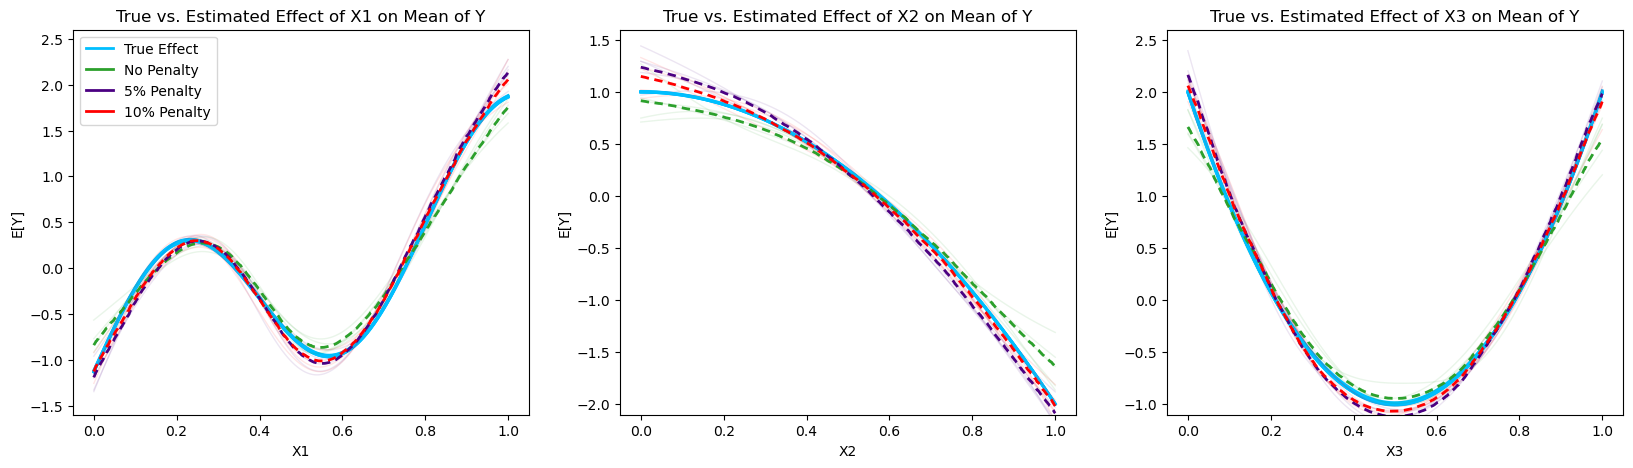

In [123]:
plot_mean_effects(sim_list_10)

In [124]:
table = simulation_mse_tables(sim_list_10)
table["Mean_MSE_Avg"] * 100

,X1,X2,X3
mu,2.042,1.956,1.982
robust_mu,1.299,1.672,1.219
strict_mu,0.923,0.641,0.729


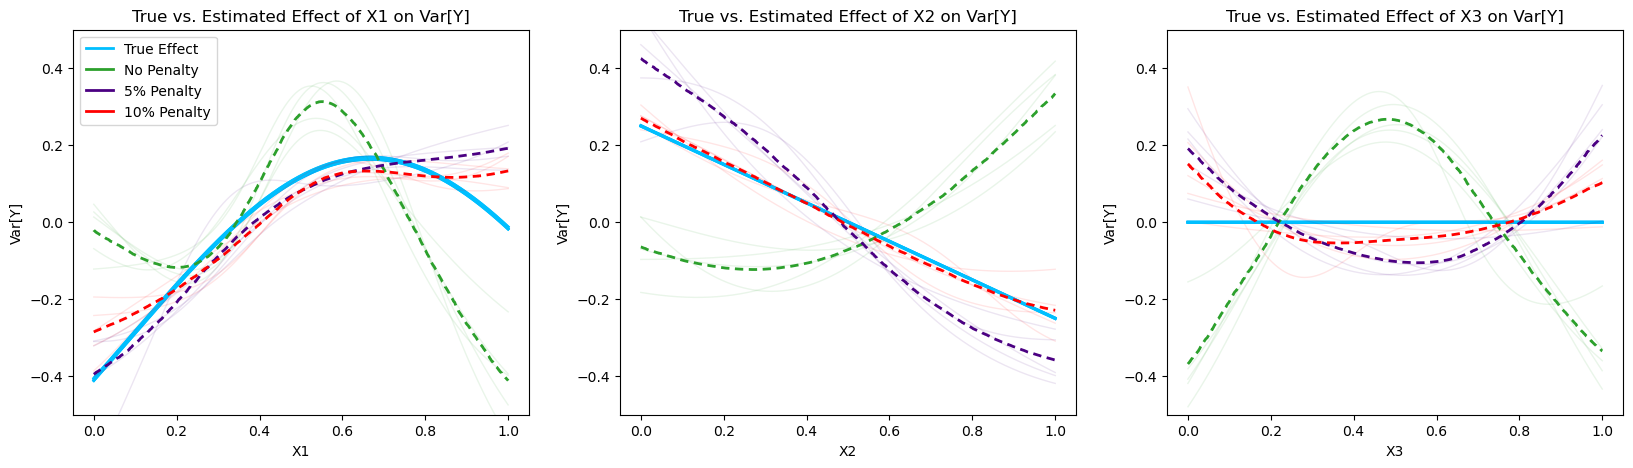

In [125]:
plot_sigma_effects(sim_list_10)

In [104]:
table["Sigma_MSE_Avg"] * 100

,X1,X2,X3
sigma,4.166,7.613,4.271
robust_sigma,0.551,1.405,1.091
strict_sigma,0.342,0.101,0.447
